# ***KNN***

In [1]:
# ============================
# IMPORTS
# ============================
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
import plotly.express as px

from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)

import lime.lime_tabular
import time

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:

# =======================
# LOAD DATA
# =======================
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# ============================
model_filename = "../Models/best_knn_model.pkl"
study_filename = "../Study/optuna_study_KNN_nested.pkl"
metrics_filename = "../Models/best_knn_metrics.pkl"
fold_metrics_filename = "./Metrics/knn_folds_summary.csv"

In [4]:

# ============================
# EVALUATION FUNCTION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [5]:
# ============================
# BUILD PIPELINE
# ============================
def build_pipeline(params, numeric_features, categorical_features):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ],
        verbose_feature_names_out=False,
        force_int_remainder_cols=False
        )
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(**params))
    ])
    return model

In [6]:
# ============================
# FOLD METRIC SAVER
# ============================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    df = pd.DataFrame(folds_metrics)
    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()
    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'
    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    df_final.to_csv(filename, index=False)
    print(f"\n📁 Fold metrics + summary saved to: {filename}")
    return df_final

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [7]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_wrapper, X_train_raw, y_train_raw):
    X_transformed = model_wrapper.preprocessor.transform(X_train_raw)
    feature_names = model_wrapper.preprocessor.get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [8]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 7, 30),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"])
        }
        
        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            model.fit(X_t, y_t)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [9]:
# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [10]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [11]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRUPO', 'Cupo',
                                                   'dias_mora_Asignacion',
                                                   'saldo_total',
                                                   'Mora_maxima_cliente__Asignacion',
                                                   'situacion', 'Vencto',
                                                   'Priorizacion',
                                                   'Priorizacion_mes_anterior',
                                                   'CONTE...
                                                                                 sparse_output=False))]),
                                                  ['Rango',
                                                   'Tipo_producto_asignacion',
                                                   'FRANJA_REAL_MAX', 'ZONA',
                                                   'Tipo_Normalizacion',
                                                   'Oficina', 'Tipo_Linea_1',
                                                   'Arquetipos',
                                                   'Ultimo_Canal_Gestion',
                                                   'CR_Ultima_Gestion_Cliente',
                                                   'CR_Mejor_Gestion_Cliente',
                                                   'NumeroCuotas'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7,
                                      weights='distance'))])

In [12]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3426
           1       0.69      0.55      0.61      1034
           2       0.70      0.38      0.49       625

    accuracy                           0.80      5085
   macro avg       0.74      0.63      0.67      5085
weighted avg       0.79      0.80      0.79      5085



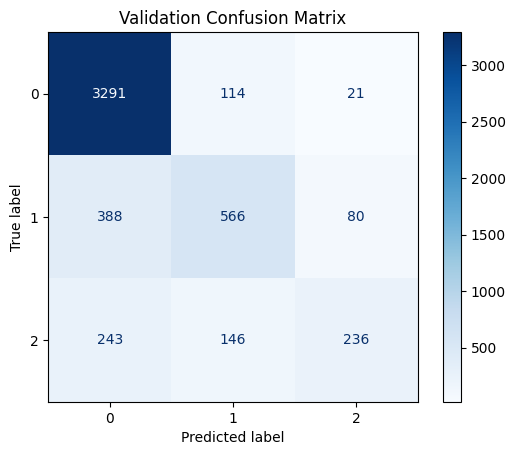

In [13]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [14]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4282
           1       0.68      0.56      0.61      1292
           2       0.69      0.37      0.48       781

    accuracy                           0.80      6355
   macro avg       0.74      0.63      0.66      6355
weighted avg       0.79      0.80      0.79      6355



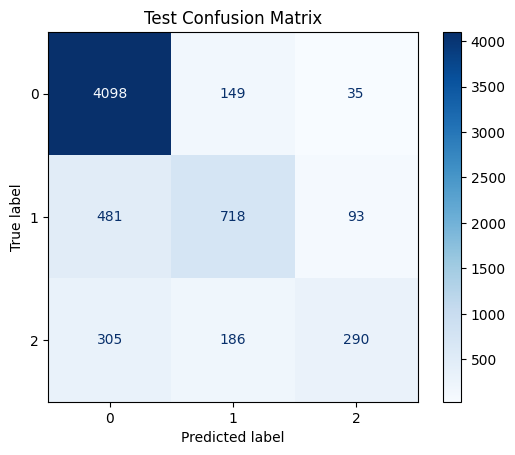

In [15]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

--- Explanation for class 0 ---


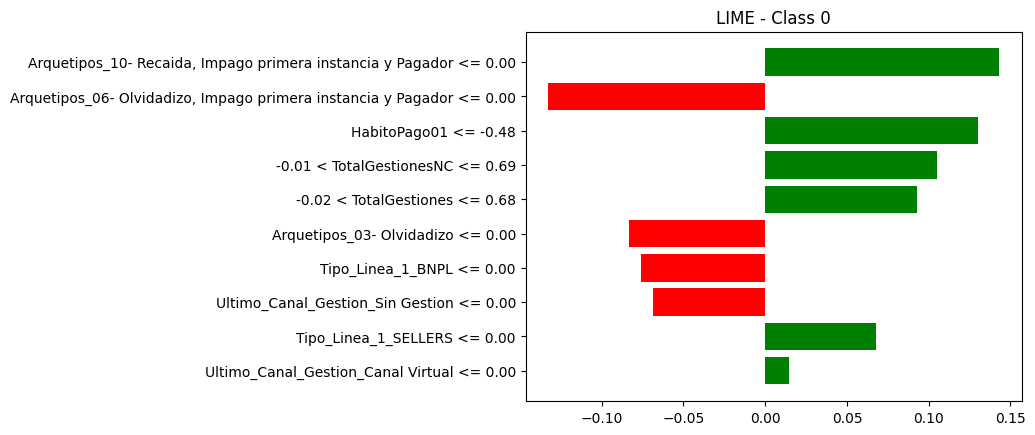

--- Explanation for class 1 ---


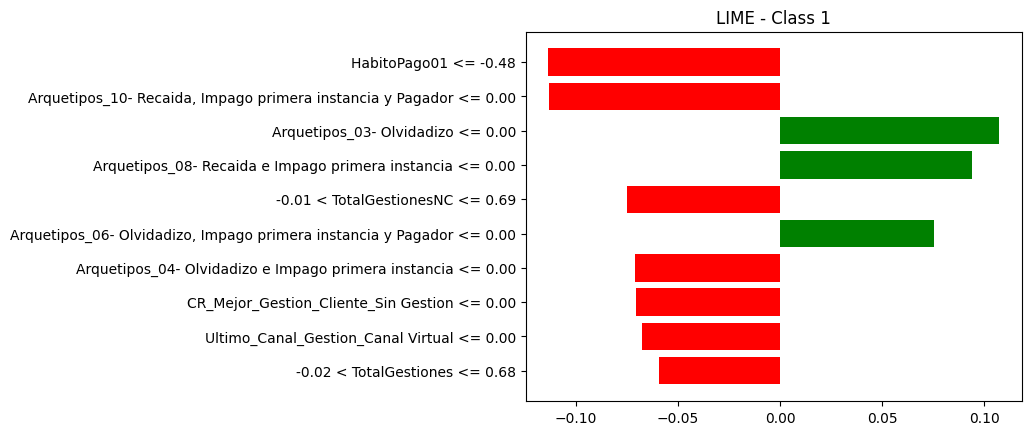

--- Explanation for class 2 ---


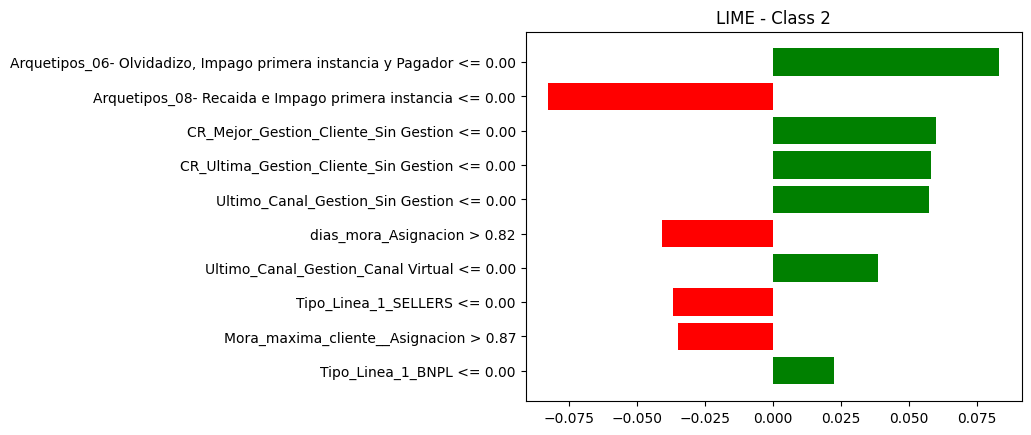

In [16]:
# ============================
# LIME EXPLANATION FOR KNN
# ============================

# Aplicar solo el preprocesamiento
X_transformed = model.named_steps["preprocessor"].transform(metrics['X_train_fold'])

# Función de predicción adaptada: NO volver a preprocesar
def predict_fn(x):
    return model.named_steps["classifier"].predict_proba(x)

# Obtener nombres de features y clases
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

# Instanciar LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Seleccionar instancia
instance = X_transformed[10]

# Explicar
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])

# Mostrar tabla
exp.show_in_notebook(show_table=True)

# Mostrar gráficas
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [17]:
visualizations['optimization_history']

In [18]:
visualizations['parallel_coordinate']

In [19]:
visualizations['f1_score_evolution']

In [20]:
visualizations['param_importances']

In [21]:
reporte.save(metrics, model_name="SVC")


✅ Report for model 'SVC' saved:
   → CSV: ./Metrics/Metrics_SVC.csv
   → JSON: ./Metrics/Metrics_SVC.json


In [22]:
df = reporte.load()


✅ Loaded 4 report(s):
   → Models: ['RF', 'LGBM', 'SVC', 'CART']
   → Types : ['train', 'val', 'test']


In [23]:
df.query("Model == 'SVC' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
36,SVC,train,0,1.0,1.0,1.0
37,SVC,train,1,1.0,1.0,1.0
38,SVC,train,2,1.0,1.0,1.0
39,SVC,train,macro avg,1.0,1.0,1.0
40,SVC,train,weighted avg,1.0,1.0,1.0


In [24]:
df.query("Model == 'SVC' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
42,SVC,val,0,0.839,0.961,0.896
43,SVC,val,1,0.685,0.547,0.609
44,SVC,val,2,0.7,0.378,0.491
45,SVC,val,macro avg,0.742,0.629,0.665
46,SVC,val,weighted avg,0.791,0.805,0.788


In [25]:
df.query("Model == 'SVC' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
48,SVC,test,0,0.839,0.957,0.894
49,SVC,test,1,0.682,0.556,0.612
50,SVC,test,2,0.694,0.371,0.484
51,SVC,test,macro avg,0.738,0.628,0.663
52,SVC,test,weighted avg,0.789,0.803,0.786


In [26]:
df.query("Model == 'SVC' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
41,SVC,train,1.0,0.0,1.0
47,SVC,val,0.805,1.847,0.893
53,SVC,test,0.803,1.919,0.894


In [27]:
df.query("Model == 'SVC' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
47,SVC,val,0.805,1.847,0.893


In [28]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


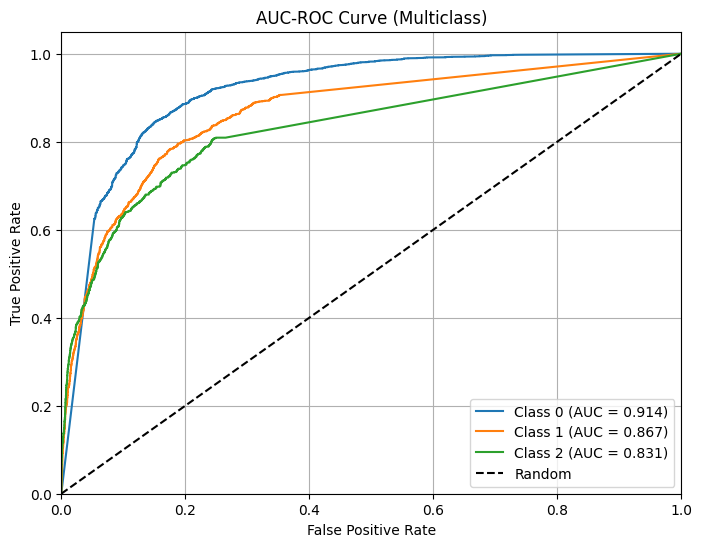

In [29]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [30]:
model.named_steps['classifier'].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'distance'}